**Stress Prediction [XGBoost | Optuna | SHAP]**

In [34]:
# pip install kagglehub[pandas-datasets] matplotlib plotly optuna shap xgboost

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.9 MB 8.3 MB/s eta 0:00:02
   -------------- ------------------------- 3.7/9.9 MB 10.9 MB/s eta 0:00:01
   ------------------------- -------------- 6.3/9.9 MB 11.5 MB/s eta 0:00:01
   --------------------------------- ------ 8.4/9.9 MB 11.1 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 10.6 MB/s  0:00:01

   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------------------------------- 0/2 [narwhals]
   ---------------

In [36]:
import kagglehub
import numpy as np
import optuna
import pandas as pd
import plotly
import shap
from kagglehub import KaggleDatasetAdapter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

**1. Wczytanie danych**

In [3]:
file_path = "stress_detection_data.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "shijo96john/stress-level-prediction",
  file_path,
)

pd.set_option('display.max_columns', None)

df.head()

,Age,Gender,Occupation,Marital_Status,Sleep_Duration,Sleep_Quality,Wake_Up_Time,Bed_Time,Physical_Activity,Screen_Time,Caffeine_Intake,Alcohol_Intake,Smoking_Habit,Work_Hours,Travel_Time,Social_Interactions,Meditation_Practice,Exercise_Type,Blood_Pressure,Cholesterol_Level,Blood_Sugar_Level,Stress_Detection
0,30,Male,Software Engineer,Single,7.0,4.0,7:00 AM,10:00 PM,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,Low
1,35,Female,Marketing Manager,Married,6.0,3.0,6:00 AM,11:00 PM,1.0,3.0,0,1,No,9,2.0,3,No,Yoga,110,160,80,Medium
2,40,Male,Data Scientist,Divorced,7.0,4.0,7:00 AM,10:00 PM,2.0,4.0,1,0,No,8,1.0,5,Yes,Strength Training,130,200,100,High
3,35,Male,Software Engineer,Single,7.0,4.0,7:00 AM,10:00 PM,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,Low
4,29,Female,Teacher,Single,8.0,5.0,6:30 AM,10:30 PM,3.0,2.0,1,0,No,7,1.0,4,Yes,Yoga,110,180,90,Low


**2. Feature Engineering / EDA**

In [4]:
df.isnull().sum()

Age                    0
Gender                 0
Occupation             0
Marital_Status         0
Sleep_Duration         0
Sleep_Quality          0
Wake_Up_Time           0
Bed_Time               0
Physical_Activity      0
Screen_Time            0
Caffeine_Intake        0
Alcohol_Intake         0
Smoking_Habit          0
Work_Hours             0
Travel_Time            0
Social_Interactions    0
Meditation_Practice    0
Exercise_Type          0
Blood_Pressure         0
Cholesterol_Level      0
Blood_Sugar_Level      0
Stress_Detection       0
dtype: int64

In [5]:
df.describe()

,Age,Sleep_Duration,Sleep_Quality,Physical_Activity,Screen_Time,Caffeine_Intake,Alcohol_Intake,Work_Hours,Travel_Time,Social_Interactions,Blood_Pressure,Cholesterol_Level,Blood_Sugar_Level
count,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000
mean,38.887451,6.338422,3.848124,2.979301,4.105433,1.818887,0.888745,8.258732,2.858344,3.196636,137.943079,220.834411,111.765847
std,7.686642,0.733584,0.545459,0.797234,0.812513,0.838396,0.673741,1.064168,1.083758,0.856332,13.122060,19.322622,12.533097
min,18.000000,3.500000,2.000000,1.000000,2.000000,0.000000,0.000000,6.000000,0.500000,1.000000,110.000000,150.000000,80.000000
25%,33.000000,6.000000,3.600000,2.000000,4.000000,1.000000,0.000000,8.000000,2.000000,3.000000,130.000000,210.000000,105.000000
50%,39.000000,6.300000,3.900000,3.000000,4.000000,2.000000,1.000000,8.000000,3.000000,3.000000,140.000000,220.000000,115.000000
75%,45.000000,7.000000,4.000000,4.000000,5.000000,2.000000,1.000000,9.000000,4.000000,4.000000,150.000000,230.000000,120.000000
max,60.000000,8.000000,5.000000,5.000000,8.000000,4.000000,2.000000,14.000000,5.000000,5.000000,170.000000,290.000000,150.000000


In [6]:
STRESS_LEVEL_MAP = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

df['Stress_Level'] = df['Stress_Detection'].map(STRESS_LEVEL_MAP)

**3. Modelowanie**

In [7]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

X = df.drop(columns=['Stress_Level', 'Stress_Detection'])
y = df['Stress_Level']

seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

model = XGBClassifier(enable_categorical=True)
model.fit(X_train, y_train)

print(model)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
Accuracy: 71.09%


**4. Optymalizacja hiperparametrów (Optuna)**

In [42]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  # default: 100
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # default: 3
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # default: 1
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # default: 0.1
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # default: 1
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # default: 1
        'gamma': trial.suggest_float('gamma', 0, 5),  # default: 0
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),  # default: 0
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),  # default: 1
        'enable_categorical': True
    }
    
    clf = XGBClassifier(**param)
    return cross_val_score(clf, X, y, n_jobs=-1, cv=5).mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=400)

trial = study.best_trial

print('Best Accuracy: {:.2f}%'.format(trial.value * 100))
print("Best hyperparameters: {}".format(trial.params))

[I 2025-11-22 12:12:23,776] A new study created in memory with name: no-name-bea57306-cea7-4a23-adef-15baa7610cb3
[I 2025-11-22 12:12:27,127] Trial 0 finished with value: 0.5113028906577293 and parameters: {'n_estimators': 285, 'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.017885117575593114, 'subsample': 0.6694327448741548, 'colsample_bytree': 0.7850531296198686, 'gamma': 4.287154012035394, 'reg_alpha': 4.374142873795927, 'reg_lambda': 4.69414001531878}. Best is trial 0 with value: 0.5113028906577293.
[I 2025-11-22 12:12:29,454] Trial 1 finished with value: 0.4931378299120235 and parameters: {'n_estimators': 345, 'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.1431935761420599, 'subsample': 0.5287359247863072, 'colsample_bytree': 0.968012623217783, 'gamma': 4.045201781328502, 'reg_alpha': 3.695222188924668, 'reg_lambda': 9.286551724924943}. Best is trial 0 with value: 0.5113028906577293.
[I 2025-11-22 12:12:29,768] Trial 2 finished with value: 0.5191286133221616

Best Accuracy: 56.70%
Best hyperparameters: {'n_estimators': 106, 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.04476323479363991, 'subsample': 0.9907900751328256, 'colsample_bytree': 0.5093741397613256, 'gamma': 0.0022130350101197847, 'reg_alpha': 0.16834009352832074, 'reg_lambda': 0.9827879367525543}


In [43]:
# TODO: resolve plotly import issue and choose one/two plots to display

# optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_slice(study)
# optuna.visualization.plot_parallel_coordinate(study)

**5. Interpretacja rezultatów (SHAP + wykresy)**

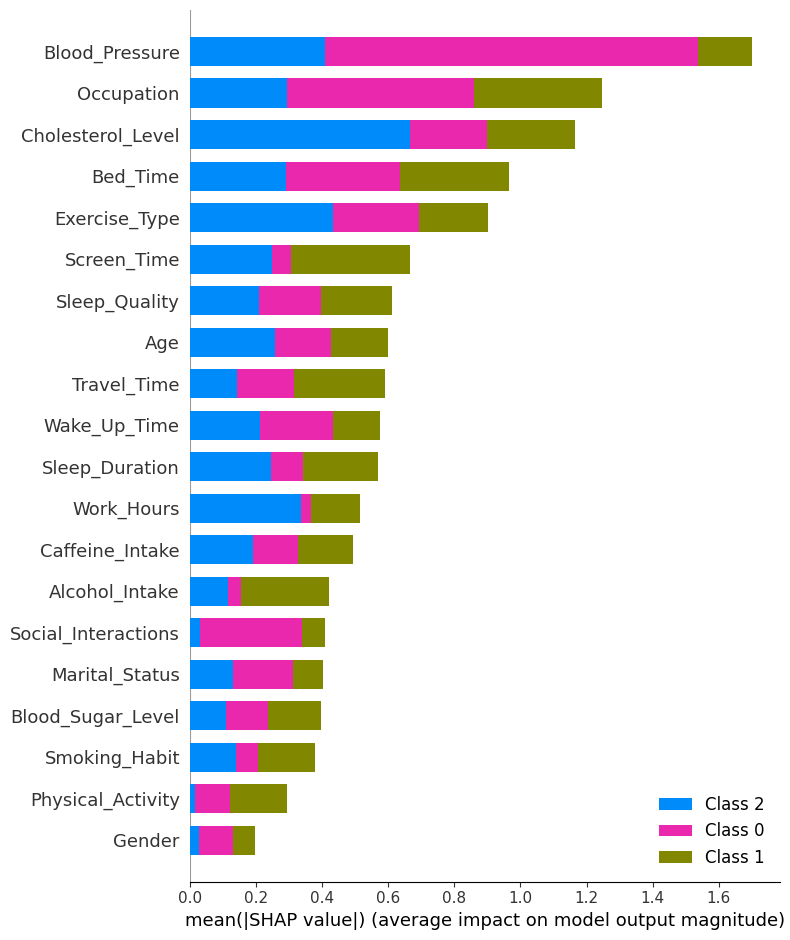

In [27]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

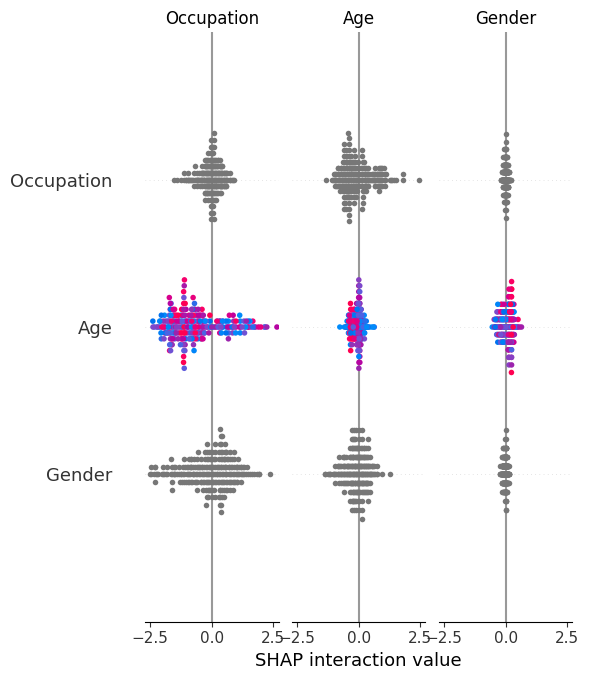

In [15]:
shap.summary_plot(shap_values, X_test)